# Machine Learning - Decision tree

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

# Part 4
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Visualize tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus 

In [2]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [3]:
def toInteger(dirc, value):
    return dirc[value]

In [4]:
data = pd.read_csv('airbnbDK', sep='\t') 

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0,1,20,47,50,60,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
dataNotNan = data.dropna(subset=['Price', 'First Review', 'Last Review', 'Latitude', 'Longitude', 'Neighbourhood', 'Host Since',
                                 'Review Scores Rating', 'Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Location',  'Review Scores Value' ])

dataNotNan.reset_index()

dataNotNan.reset_index()
print("Data before clean", len(data), "\nData after clean", len(dataNotNan))

Data before clean 20548 
Data after clean 9509


In [6]:
cityAreas = {
    'Amager Vest': 'Amager Vest', 
    'Amagerbro':'Amager Øst',
    'Amager Øst':'Amager Øst',
    'Brønshøj':'Brønshøj-Husum ',
    'Christianshavn':'Christianshavn',
    'Frederiksberg':'Frederiksberg',
    'Holmen':'Indre By',
    'Indre By':'Indre By',
    'Islands Brygge':'Amager Vest',
    'København NV':'Bispebjerg',
    'Kødbyen':'Vesterbro',
    'Nyboder':'Østerbro',
    'Nørrebro':'Nørrebro',
    'Sluseholmen':'Kongens Enghave',
    'Teglholmen':'Kongens Enghave',
    'Valby':'Valby',
    'Vanløse':'Vanløse',
    'Vesterbro':'Vesterbro',
    'Østerbro':'Østerbro',
    'Kastrup':'Amager Vest'
}

# Find District
dataNotNan.loc[:,'District'] = [cityAreas[n] for n in dataNotNan['Neighbourhood'].values]
set(dataNotNan['District'])

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


{'Amager Vest',
 'Amager Øst',
 'Bispebjerg',
 'Brønshøj-Husum ',
 'Christianshavn',
 'Frederiksberg',
 'Indre By',
 'Kongens Enghave',
 'Nørrebro',
 'Valby',
 'Vanløse',
 'Vesterbro',
 'Østerbro'}

In [7]:
# Round price to nearest 200
dataNotNan.loc[:,'Price to nearest 200'] = [p-p%200 if p%200 < 100 else p+(200-p%200) for p in dataNotNan['Price'].copy().values]
dataNotNan.groupby(['Price to nearest 200']).count()['ID']

Price to nearest 200
0.0          3
200.0      732
400.0     2801
600.0     2797
800.0     2318
1000.0     858
Name: ID, dtype: int64

In [26]:
chosenAttributes = ['House Rules', 
                    'Host ID', 
                    'Host Since', 
                    'Host Response Rate', 
                    'Zipcode', # 4
                    'District',
                    'Property Type',
                    'Accommodates', # 8
                    'Bathrooms', 
                    'Bedrooms', # 10
                    'Beds', 
                    'Square Feet', 
                    'Weekly Price',
                    'Monthly Price',
                    'Security Deposit',
                    'Cleaning Fee', #16
                    'Guests Included',
                    'Extra People',
                    'Minimum Nights',
                    'Maximum Nights',
                    'Has Availability',
                    'Availability 30', #22
                    'Availability 60', #23
                    'Availability 90',
                    'Availability 365',
                    'Number of Reviews',
                    'Review Scores Rating',
                    'Review Scores Accuracy',
                    'Review Scores Cleanliness',
                    'Review Scores Checkin',
                    'Review Scores Communication',
                    'Review Scores Location',
                    'Review Scores Value',
                    'Cancellation Policy',
                    'Calculated host listings count',
                    'Reviews per Month']

result = 'Price to nearest 200'

In [9]:
districtMap = {'Indre By': 1,'Christianshavn': 2,'Vesterbro': 3,
               'Frederiksberg':4,'Nørrebro': 5,
               'Østerbro': 6,'Amager Øst': 7,
               'Amager Vest': 8, 'Kongens Enghave': 9,
               'Valby': 10, 'Vanløse': 11,
               'Bispebjerg': 12, 'Brønshøj-Husum ': 13}

In [10]:
propertyTypeMap = {
    'Other': 1, 'Tent': 2,
    'Boat': 3, 'Camper/RV': 4,
    'Dorm': 5, 'Loft': 6,
    'Cabin': 7, 'Bed & Breakfast': 8,
    'Boutique hotel': 9, 'Apartment': 10,
    'Condominium': 11, 'Guesthouse': 12,
    'Treehouse': 13, 'Townhouse': 14,
    'House': 15, 'Villa': 16}

In [11]:
cancellationPolicyMap = {'flexible': 1,'moderate': 2, 'strict': 3}

In [12]:
treeInput = dataNotNan[chosenAttributes]
treeOutput = dataNotNan[result]
print(len(treeInput), len(treeOutput))

9509 9509


In [13]:
def getLen(x):
    try:
        float(x)
        return 0
    except ValueError:
        return len(x)
    
def getInt(x):
    try:
        int(str(x)[:4])
        return int(str(x)[:4])
    except ValueError:
        return 0

def nanToZerofloat(x):
    if isfloat(x):
        return nanTozero(float(x))
    else:
        try:
            float(x)
            print(x, type(x))
            return nanTozero(float(x))
        except ValueError:
            print(x, type(x))
            return 0.0

def nanTozero(x):
    if math.isnan(x):
        return 0.0
    else:
        return float(x)

In [14]:
# change input data
treeInput['House Rules'] = treeInput['House Rules'].apply(lambda x: getLen(x))
treeInput['Host Since'] = treeInput['Host Since'].apply(lambda x: int(''.join(c for c in x if c.isdigit())))
treeInput['Zipcode'] = treeInput['Zipcode'].apply(lambda x: getInt(x))
treeInput['Property Type'] = treeInput['Property Type'].apply(lambda x: toInteger(propertyTypeMap,x))
treeInput['Cancellation Policy'] = treeInput['Cancellation Policy'].apply(lambda x: toInteger(cancellationPolicyMap,x))
treeInput['District'] = treeInput['District'].apply(lambda x: toInteger(districtMap,x))

temp = ['House Rules','Host Since','Zipcode','Property Type','Cancellation Policy','District']

for key in treeInput.keys():
    if key not in temp:
        treeInput[key] = treeInput[key].apply(lambda x: nanToZerofloat(x))



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [15]:
[print(idx, "-", type(treeInput.values[0][idx]), "-", treeInput.values[0][idx][:20]) 
     if not isfloat(treeInput.values[0][idx]) else 
 print(idx, "-", type(treeInput.values[0][idx]), "-", treeInput.values[0][idx]) 
 for idx in range(len(treeInput.values[0]))]


0 - <class 'numpy.float64'> - 291.0
1 - <class 'numpy.float64'> - 74785241.0
2 - <class 'numpy.float64'> - 20160530.0
3 - <class 'numpy.float64'> - 100.0
4 - <class 'numpy.float64'> - 2400.0
5 - <class 'numpy.float64'> - 11.0
6 - <class 'numpy.float64'> - 10.0
7 - <class 'numpy.float64'> - 4.0
8 - <class 'numpy.float64'> - 1.0
9 - <class 'numpy.float64'> - 2.0
10 - <class 'numpy.float64'> - 3.0
11 - <class 'numpy.float64'> - 0.0
12 - <class 'numpy.float64'> - 0.0
13 - <class 'numpy.float64'> - 0.0
14 - <class 'numpy.float64'> - 0.0
15 - <class 'numpy.float64'> - 400.0
16 - <class 'numpy.float64'> - 2.0
17 - <class 'numpy.float64'> - 100.0
18 - <class 'numpy.float64'> - 2.0
19 - <class 'numpy.float64'> - 28.0
20 - <class 'numpy.float64'> - 0.0
21 - <class 'numpy.float64'> - 2.0
22 - <class 'numpy.float64'> - 21.0
23 - <class 'numpy.float64'> - 32.0
24 - <class 'numpy.float64'> - 51.0
25 - <class 'numpy.float64'> - 26.0
26 - <class 'numpy.float64'> - 97.0
27 - <class 'numpy.float64'> - 1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [16]:
gini_max = [0,0]
entropy_max = [0,0]
for i in np.linspace(1,31,16):
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=i)
    cv_results = cross_validate(clf_gini, treeInput, treeOutput, cv=10, return_train_score=False)
    
    if np.mean(cv_results['test_score']) > gini_max[0]:
        gini_max[0] = np.max(cv_results['test_score'])
        gini_max[1] = i
    
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth=i)
    cv_results = cross_validate(clf_entropy, treeInput, treeOutput, cv=10, return_train_score=False)
    if np.mean(cv_results['test_score']) > entropy_max[0]:
        entropy_max[0] = np.max(cv_results['test_score'])
        entropy_max[1] = i

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number 

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [17]:
print("The best test score for Gini is %.2f%% with max depth %d" % (gini_max[0]*100,gini_max[1]))
print("The best test score for Entropy is %.2f%% with max depth %d" % (entropy_max[0]*100,entropy_max[1]))



The best test score for Gini is 43.44% with max depth 3
The best test score for Entropy is 43.13% with max depth 3


In [18]:
def plotTree(dtree):
    dot_data = StringIO()
    export_graphviz(dtree, 
                    out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

The accuracy of gini with a max depth of 3 is 41.36% 


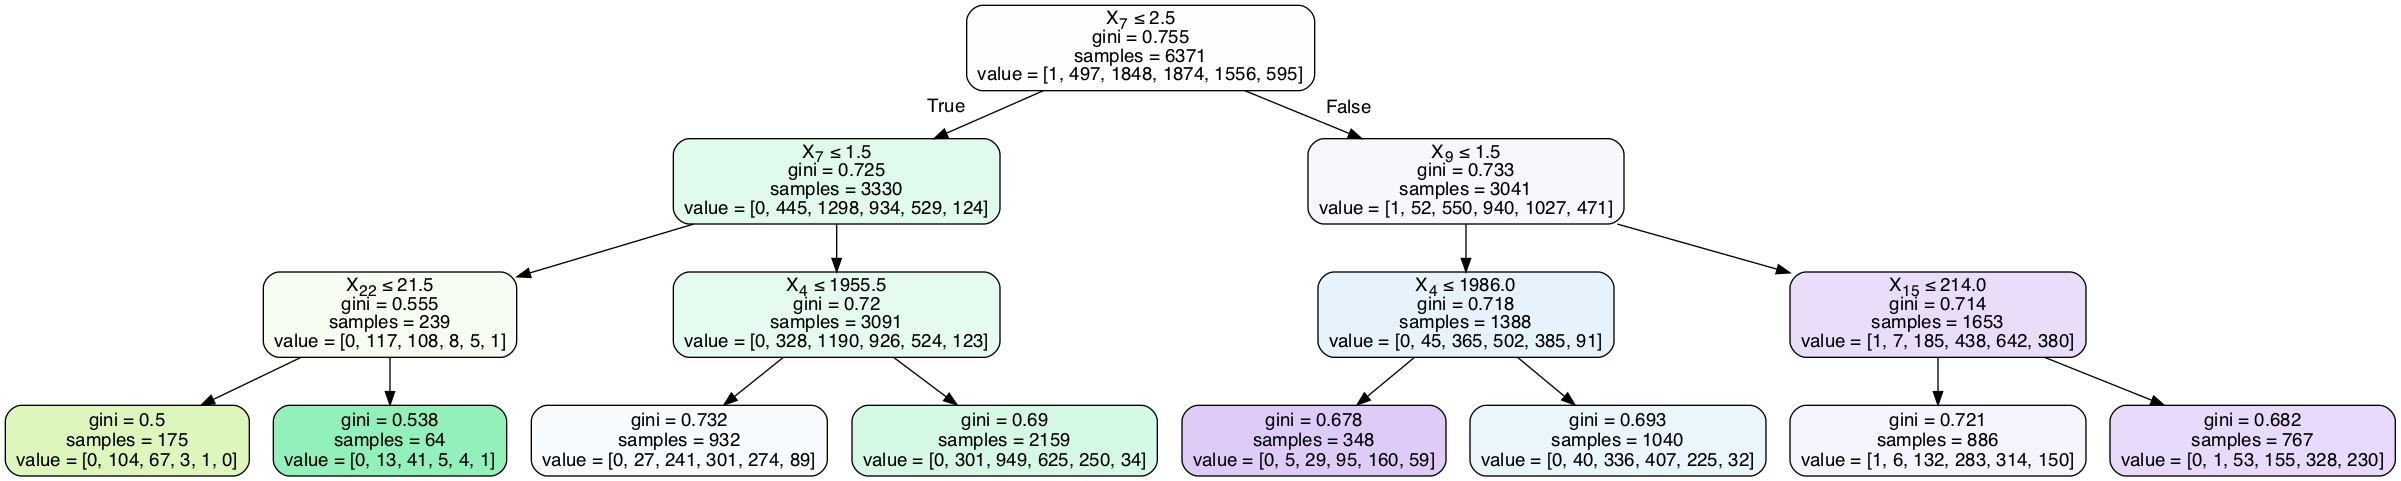

In [19]:
# plotting simple Gini
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# devide data
X_train, X_test, y_train, y_test = train_test_split(treeInput, treeOutput, test_size=0.33)

# recreate the best model
clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=3)
dtree_gini = clf_gini.fit(X_train, y_train) 

# predicting
y_pred = dtree_gini.predict(X_test)
print("The accuracy of gini with a max depth of 3 is %.2f%% " % 
      (accuracy_score(y_test, y_pred)*100))

# plot the best model *
plotTree(dtree_gini)

We try to fit a decision tree to 36 attributes which have been listed in chosenAttributes.
The inted is to predict the price class of airbnb housings. 

The some attributes of the data are roughly convereted to floats to initially get a idea of which values have most in common with given price class. 

As seen above, only 4-5 different attributes can categorize the data into the price-classes with ony ~41% accuracy. This shows that there are some proportional attributes, such as 'Accommodates', 'Zipcode', 'Bedrooms', 'Cleaning Fee', and some sort of 'Availability' attribute. The results make good sence when looking at them:
* Accommodates: If the airbnb can accommodate many, the overall price is higher given more poeple to pay.
* Zipcode: The area from where the airbnb is placed influence the price because of transportation etc.
* Bedrooms: More bedrooms, more poeple it can house
* Cleaning Fee: ekstra fee to the cost, or perhaps a percentage of the rental price
* Availability: The more available the higher price, which is a bit interesting, though perhaps this attribute tells something about the host's experience in the field.

However given the decision tree it seem as many of the other attributes does not seem to have mutch in common with the airbnb's price class, as the optimal depth is calculated to be 3.

It should be mentioned that some attributes are norminal, these values should be 1-of-k encoded, however have simply been mapped to an integer given the best of our intentions. Attributes such as 'Host ID', 'District', and 'Property Tupe' should be 1-of-k encoded since the actual value of the integer does not influence the order. This may result en a slightly worse accuracy, as they may have a greater influence, though due to the small accuracy and the many 'nan' values in the dataset, we have chosen to conclude our descision tree descovery.

